In [13]:
import pandas as pd
from tqdm.autonotebook import tqdm
from statsforecast import StatsForecast
import os

os.environ['NIXTLA_ID_AS_COL'] = '1'
Y_df = pd.read_parquet(
    'https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [24]:
import pandas as pd

# Sample dataframe
data = {
    'date': ['2024-01-01', '2024-01-02', '2024-01-03'],
    'series1': [10, 20, 30],
    'series2': [15, 25, 35]
}

df = pd.DataFrame(data)

# Melt the dataframe
melted_df = pd.melt(df, id_vars=['date'], var_name='ID', value_name='value')

# Rename the columns to match your requirement
melted_df.columns = ['timestamp', 'ID', 'value']

print(melted_df)

    timestamp       ID  value
0  2024-01-01  series1     10
1  2024-01-02  series1     20
2  2024-01-03  series1     30
3  2024-01-01  series2     15
4  2024-01-02  series2     25
5  2024-01-03  series2     35


In [242]:
all_data = pd.read_excel(
    r"C:\Users\zeroi\Desktop\Asignaturas\Año 3\Semestre 2\Cuantitative Macroeconomics\Fred_Data_Proyect.xlsx", sheet_name=1, index_col=0)
inflation_direct_data = all_data[["CPI_ALL_ITEMS", "M2", "M2_REAL", "M2_VELOCITY",
                                  "GDP_REAL", "FULL_TIME_NOMINAL_WEEKLY_WAGE"]].pct_change(fill_method=None)
inflation_direct_data.columns = inflation_direct_data.columns+" %"
all_data.reset_index(inplace=True)
inflation_direct_data.reset_index(inplace=True)

In [243]:
# convert data long format
# Make the data appear alongisde
inflation_direct_data_long = inflation_direct_data.melt(
    id_vars=['date'], var_name='ID', value_name='value')
# all_data_long['date'] = pd.to_datetime(all_data_long['date'])
inflation_direct_data_long["ID"] = inflation_direct_data_long["ID"].astype(
    'category')

inflation_direct_data_long = inflation_direct_data_long[[
    "ID", "date", "value"]]
inflation_direct_data_long

,ID,date,value
0,CPI_ALL_ITEMS %,1919-01-01,NaN
1,CPI_ALL_ITEMS %,1919-04-01,NaN
2,CPI_ALL_ITEMS %,1919-07-01,NaN
3,CPI_ALL_ITEMS %,1919-10-01,NaN
4,CPI_ALL_ITEMS %,1920-01-01,NaN
...,...,...,...
2521,FULL_TIME_NOMINAL_WEEKLY_WAGE %,2023-01-01,0.011080
2522,FULL_TIME_NOMINAL_WEEKLY_WAGE %,2023-04-01,0.010959
2523,FULL_TIME_NOMINAL_WEEKLY_WAGE %,2023-07-01,0.010840
2524,FULL_TIME_NOMINAL_WEEKLY_WAGE %,2023-10-01,0.020554


In [256]:
StatsForecast.plot(inflation_direct_data_long, id_col="ID",
                   time_col="date", target_col="value", engine="plotly", max_insample_length=50)

In [257]:
# Train multiple models for many series
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)
# Create a list of models and instantiation parameters
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24)
]

In [260]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    models=models,  # models to be used
    freq="QS",  # frequency of the data used
    # model to use if a model fail
    fallback_model=SeasonalNaive(season_length=7),
    n_jobs=-1,  # use all cores of the pc for parallel computing
)

In [263]:
forecasts_df = sf.forecast(df=inflation_direct_data_long,
                           h=48,  # how manu periods into the future
                           level=[90],  # 90% confidence
                           id_col="ID",
                           time_col="date",
                           target_col="value")

In [266]:
forecasts_df.head()

,ID,date,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,CPI_ALL_ITEMS %,2024-04-01,0.013583,-0.014285,0.041452,0.013583,-0.014285,0.041452,0.005444,-0.011063,0.021951,NaN,NaN,NaN,0.013583,-0.014285,0.041452
1,CPI_ALL_ITEMS %,2024-07-01,0.010252,-0.017617,0.038120,0.010252,-0.017617,0.038120,0.004018,-0.012489,0.020525,NaN,NaN,NaN,0.010252,-0.017617,0.038120
2,CPI_ALL_ITEMS %,2024-10-01,0.009398,-0.018470,0.037267,0.009398,-0.018470,0.037267,0.004071,-0.012436,0.020578,NaN,NaN,NaN,0.009398,-0.018470,0.037267
3,CPI_ALL_ITEMS %,2025-01-01,0.006705,-0.021164,0.034573,0.006705,-0.021164,0.034573,0.002782,-0.013725,0.019289,NaN,NaN,NaN,0.006705,-0.021164,0.034573
4,CPI_ALL_ITEMS %,2025-04-01,0.008840,-0.019028,0.036709,0.008840,-0.019028,0.036709,0.007127,-0.009380,0.023634,NaN,NaN,NaN,0.008840,-0.019028,0.036709


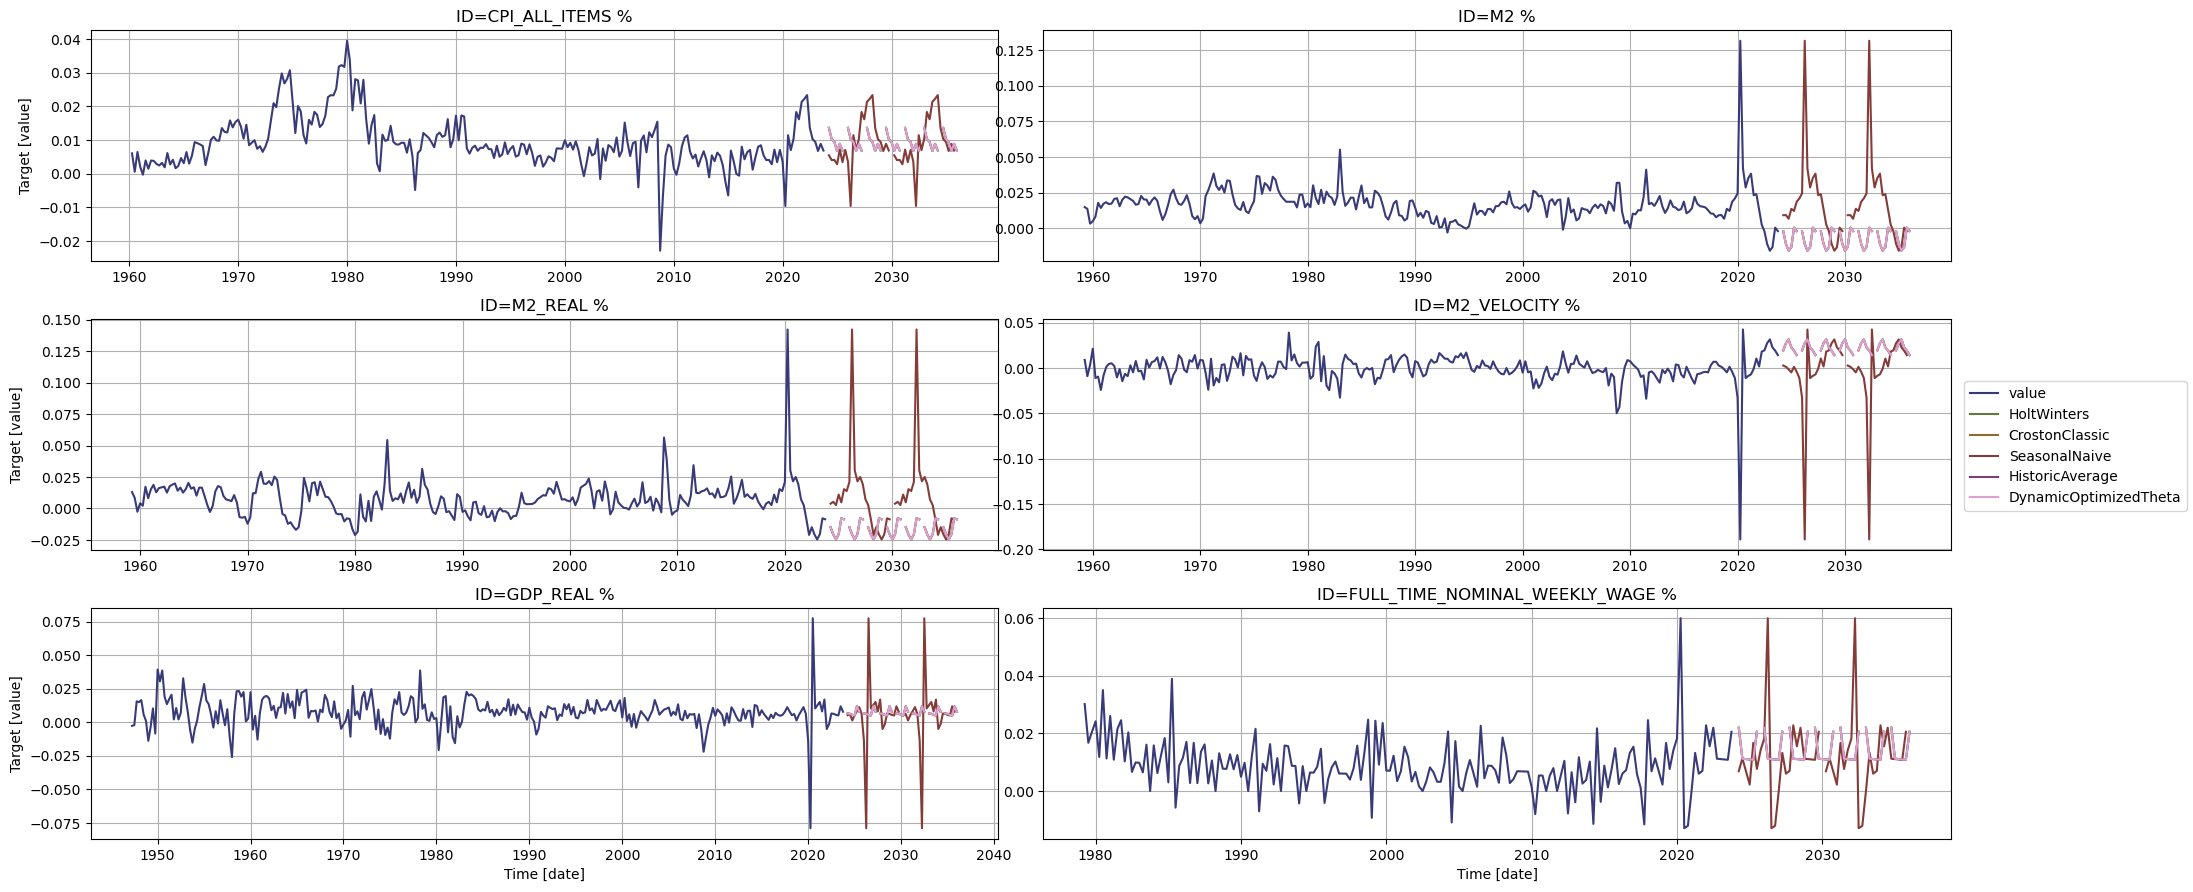

In [270]:
# Plot predictions
sf.plot(inflation_direct_data_long, forecasts_df,
        id_col="ID", time_col="date", target_col="value")

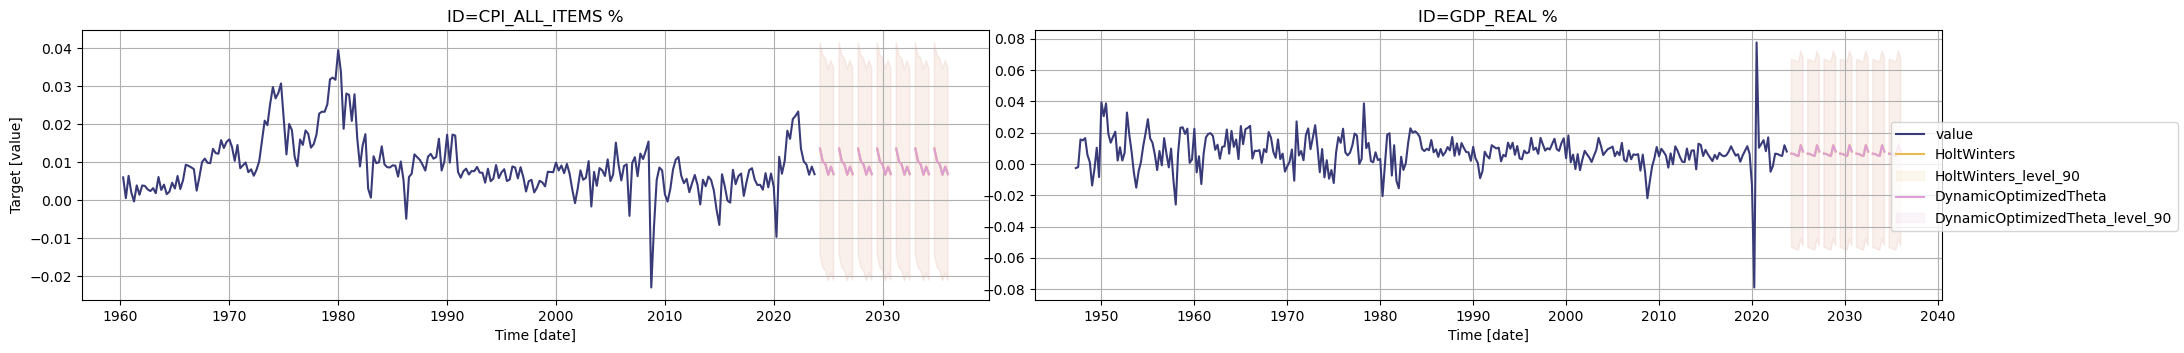

In [277]:
sf.plot(inflation_direct_data_long, forecasts_df, models=["HoltWinters", "DynamicOptimizedTheta"], unique_ids=[
        "CPI_ALL_ITEMS %", "GDP_REAL %"], level=[90], id_col="ID", time_col="date", target_col="value")

In [280]:
# Evaluate performance
# cross validation: Partir muestra de datos en trozos. Luego, con los datos de un trozo predecir trozo siguiente
crossvaldation_df = sf.cross_validation(
    df=inflation_direct_data_long,  # dataset
    h=24,  # steps into the future to forcast
    step_size=24,  # step size between each windown of forecast
    n_windows=2,  # cuantos forcast del pasado quieres evaluar
    id_col="ID",
    time_col="date",
    target_col="value")

In [288]:
crossvaldation_df.head()

,ID,date,cutoff,y,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
0,CPI_ALL_ITEMS %,2012-04-01,2012-01-01,0.002111,0.002931,0.007693,0.009024,NaN,0.002931
1,CPI_ALL_ITEMS %,2012-07-01,2012-01-01,0.004515,0.008097,0.007693,0.009440,NaN,0.008097
2,CPI_ALL_ITEMS %,2012-10-01,2012-01-01,0.006650,0.010672,0.007693,-0.004102,NaN,0.010672
3,CPI_ALL_ITEMS %,2013-01-01,2012-01-01,0.004020,0.011370,0.007693,0.009804,NaN,0.011370
4,CPI_ALL_ITEMS %,2013-04-01,2012-01-01,-0.001095,0.006521,0.007693,0.011326,NaN,0.006521


In [293]:
# Evaluate models
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate


def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ID', 'date', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff],
                         metrics=[metric], models=models,
                         id_col='ID', target_col='y', time_col='date')
        evals.append(eval_)
    evals = pd.concat(evals)
    # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals = evals.groupby('ID').mean(numeric_only=True)
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

C:\Users\zeroi\AppData\Local\Temp\ipykernel_18820\658616158.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
ID,,,,,,
CPI_ALL_ITEMS %,0.000050,0.000047,0.000083,NaN,0.000050,CrostonClassic
FULL_TIME_NOMINAL_WEEKLY_WAGE %,0.000192,0.000136,0.000271,NaN,0.000192,CrostonClassic
GDP_REAL %,0.000307,0.000297,0.000332,NaN,0.000307,CrostonClassic
M2 %,0.000473,0.000430,0.000482,NaN,0.000473,CrostonClassic
M2_REAL %,0.000571,0.000549,0.000643,NaN,0.000571,CrostonClassic


In [295]:
# For how many series are each model the best
summary_df = evaluation_df.groupby(
    'best_model').size().sort_values().to_frame()
summary_df.reset_index().columns = ["Model", "Nr. of unique_ids"]
summary_df

,0
best_model,
HoltWinters,1
CrostonClassic,5


In [305]:
# Select best model
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['ID', 'date']).stack(
    ).to_frame().reset_index(level=2)  # Wide to long
    df.columns = ['model', 'best_model_forecast']
    df = df.join(evaluation_df[['best_model']])
    df = df.query(
        'model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(
        bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index(
        'model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df


prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df

,ID,date,best_model,best_model-hi-90,best_model-lo-90
0,CPI_ALL_ITEMS %,2024-04-01,0.013583,0.041452,-0.014285
1,CPI_ALL_ITEMS %,2024-07-01,0.010252,0.038120,-0.017617
2,CPI_ALL_ITEMS %,2024-10-01,0.009398,0.037267,-0.018470
3,CPI_ALL_ITEMS %,2025-01-01,0.006705,0.034573,-0.021164
4,CPI_ALL_ITEMS %,2025-04-01,0.008840,0.036709,-0.019028
...,...,...,...,...,...
247,M2_VELOCITY %,2035-01-01,0.027454,0.107773,-0.052865
248,M2_VELOCITY %,2035-04-01,0.031579,0.111898,-0.048740
249,M2_VELOCITY %,2035-07-01,0.022763,0.103082,-0.057556
250,M2_VELOCITY %,2035-10-01,0.019186,0.099505,-0.061132


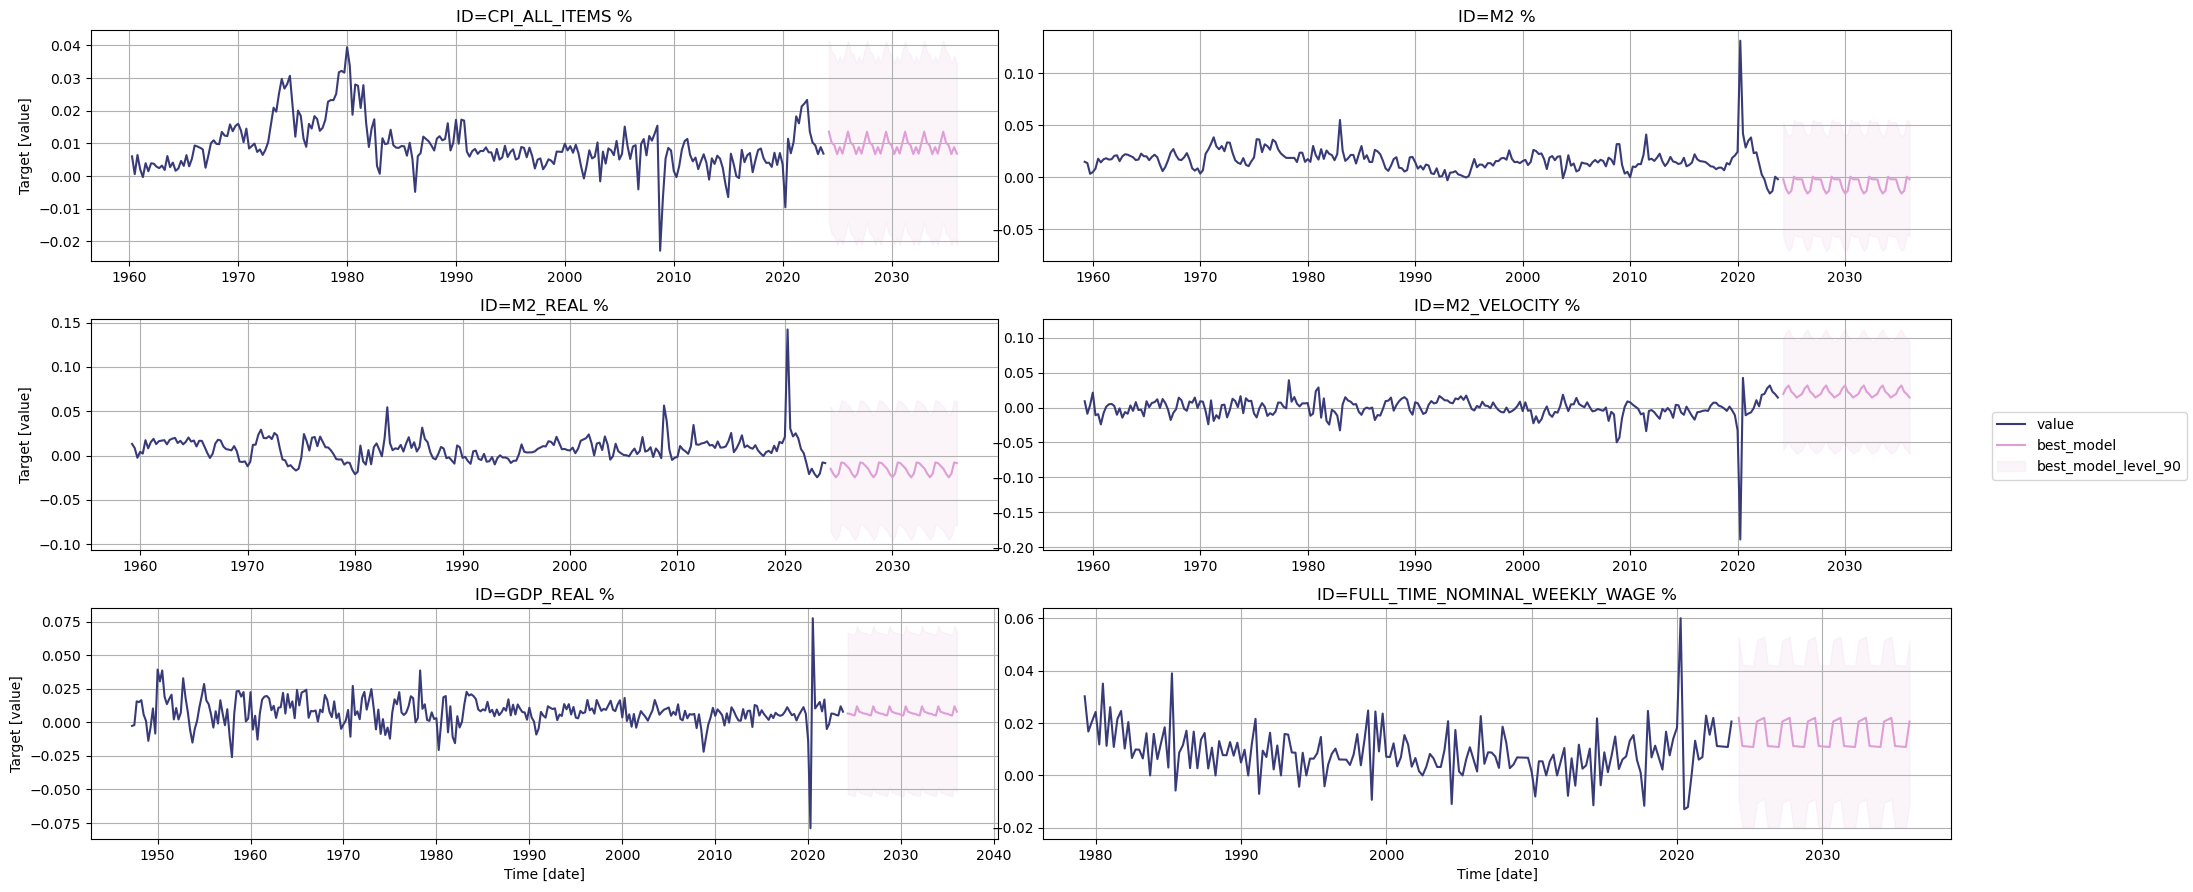

In [308]:
# Plot the results
sf.plot(inflation_direct_data_long, prod_forecasts_df, level=[90],
        id_col="ID",
        time_col="date",
        target_col="value")

#### Garch

In [309]:
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor': '#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12}
plt.rcParams.update(dark_style)

rcParams['figure.figsize'] = (18, 7)

In [310]:
import pandas as pd
import time
from datetime import datetime

ticker = '^GSPC'
period1 = int(time.mktime(datetime(2015, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.now().timetuple()))
interval = '1d'  # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

SP_500 = pd.read_csv(query_string)
SP_500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
1,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
3,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
4,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [319]:
df = SP_500[["Date", "Close"]]
df["unique_id"] = "1"
df.columns = ["ds", "y", "unique_id"]
df["ds"] = pd.to_datetime(df["ds"])

C:\Users\zeroi\AppData\Local\Temp\ipykernel_18820\1450188691.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\zeroi\AppData\Local\Temp\ipykernel_18820\1450188691.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



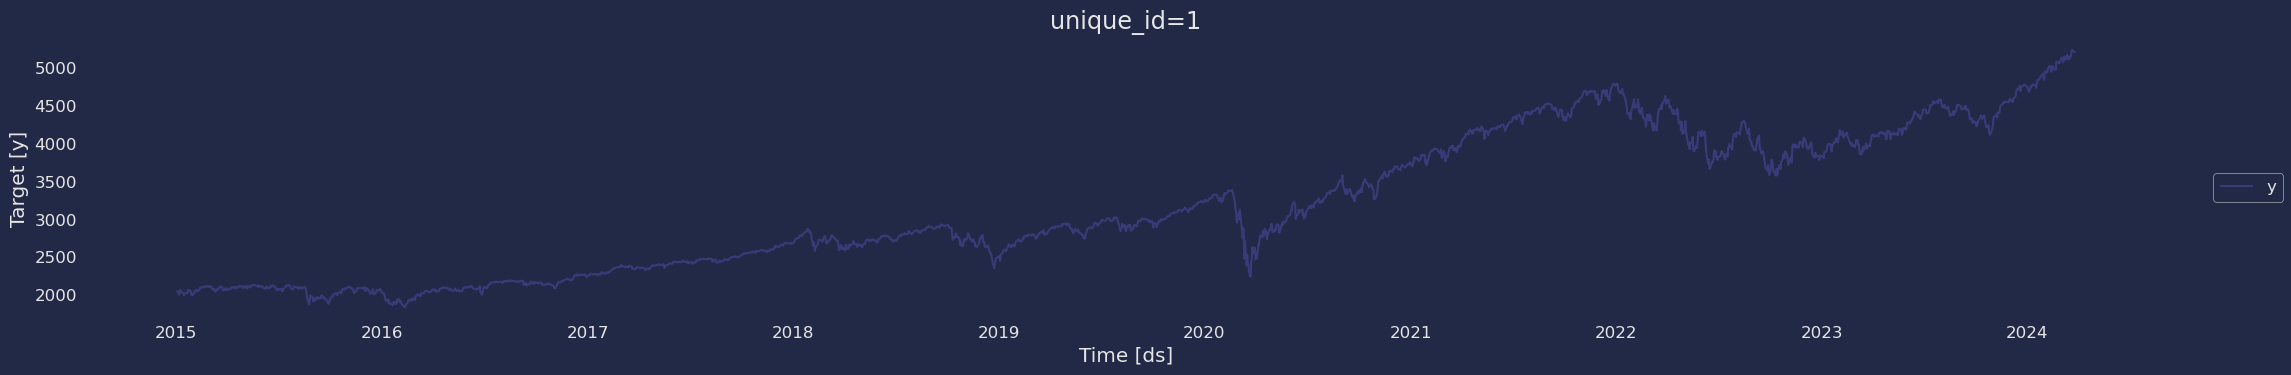

In [321]:
# Explore
from statsforecast import StatsForecast

StatsForecast.plot(df)


In [327]:
# ADF test as seen in class
def ADF_test(timeseries, IC="bic", significance=0.01):
    """
    Performs Augmented Dickey-Fuller (ADF) test with additional outputs.

    Args:
        timeseries (array-like): The time series data to be tested.
        IC (str): Information criterion to use for selecting the lag order. ["bic","aic"]
        significance (float): Significance level for hypothesis testing.

    Returns:
        Analysis of unit root type

    """
    import warnings
    warnings.simplefilter('ignore', category=UserWarning)
    from arch.unitroot import ADF
    import statsmodels.tsa.arima.model as smt

    # Step 1: Perform ADF test with constant and trend
    print("Step 1: Performing ADF test with constant and trend...")
    adf = ADF(timeseries, trend="ct", method=IC)
    print("Results of Dickey-Fuller Test:")
    print(f"       p-value of the test: {adf.pvalue}.")
    if adf.pvalue < significance:
         print(
            "       Conclusion: We reject the null hypothesis -> [The series has no unit root, it might still have trend]")
    else:
        print("       We do not reject the null hypothesis -> Proceeding to step 2...")
        # Step 2: Test for the significance of the trend given no unit root
        print("Step 2: Testing for the significance of the trend given no unit root...")
        model_2 = smt.ARIMA(endog=timeseries.diff(),
                            order=(adf.lags, 0, 0), trend="ct").fit(cov_type="robust")
        p_value_trend = model_2.pvalues["x1"]
        print("Results of the contrast:")
        print(f"       p-value of the contrast: {p_value_trend}")
        if p_value_trend < significance:
            print(
                "       Conclusion: We reject the null hypothesis -> Might try again to see whether the unit root is significant, but with a normal distribution (see below output) -> [Model: Unit Root with c and t][Trend Stationary: y_t=alpha+beta*t+y_{t-1}+epsilon_t]")
            print(adf.regression.summary())
            print("Info: These p-values are computed over the normal distribution. Errors are WN. Look at Level.L1 significance to determine whether there is a Unit Root (null hypothesis) or not as described above.")
        else:
            print(
                "       We do not reject the null hypothesis -> Proceeding to step 3...")
            # Step 3: Perform ADF test with only a constant
            print("Step 3: Performing ADF test with only a constant...")
            print("Results of Dickey-Fuller Test:")
            adf = ADF(timeseries, method=IC, trend="c")
            print(f"       p-value of the test: {adf.pvalue}.")
            if adf.pvalue < significance:
                print(
                    "       Conclusion: We reject the null hypothesis -> [The series has no unit root, it might still have trend]")
            else:
                print(
                    "       Can't reject the null hypothesis -> Proceeding to step 4...")
                # Step 4: Test for the significance of the constant given no unit root and no trend
                print(
                    "Step 4: Testing for the significance of the constant given no unit root and no trend...")
                model_3 = smt.ARIMA(endog=timeseries.diff(),
                                    order=(adf.lags, 0, 0), trend="c").fit(cov_type="robust")
                p_value_const = model_3.pvalues["const"]
                print("Results of the contrast:")
                print(f"       p-value of the contrast: {p_value_const}")
                if p_value_const < significance:
                    print(
                        "         Conclusion: We reject the null hypothesis -> Might try again to see whether the unit root is significant, but with a normal distribution (see below output) -> [Model: Unit Root with c and no t][White Noise with Drift: y_t= alpha + y_{t-1} + epsilon_t]")
                    print(adf.regression.summary())
                    print("Info: These p-values are computed over the normal distribution. Errors are WN. Look at Level.L1 significance to determine whether there is a Unit Root (null hypothesis) or not as described above.")
                else:
                    print(
                        "       We do not reject the null hypothesis -> Proceeding to step 5...")
                    # Step 5: Perform ADF test with no constant and no trend
                    print(
                        "Step 5: Performing ADF test with no constant and no trend...")
                    adf = ADF(timeseries, method=IC, trend="n")
                    print("Results of Dickey-Fuller Test:")
                    print(f"       p-value of the test: {adf.pvalue}.")
                    if adf.pvalue < significance:
                        print(
                            "       Conclusion: We reject the null hypothesis -> [The series has no unit root, it might still have trend]")
                    else:
                        print(
                            "       Conclusion: We do not reject the null hypothesis ->[The model has a unit root with no constant or trend]=[Pure White Noise: y_t= y_{t-1} + epsilon_t].")


ADF_test(df["y"], significance=0.05,IC="aic")

Step 1: Performing ADF test with constant and trend...
Results of Dickey-Fuller Test:
       p-value of the test: 0.21081513608397034.
       We do not reject the null hypothesis -> Proceeding to step 2...
Step 2: Testing for the significance of the trend given no unit root...
Results of the contrast:
       p-value of the contrast: 0.3168420527085519
       We do not reject the null hypothesis -> Proceeding to step 3...
Step 3: Performing ADF test with only a constant...
Results of Dickey-Fuller Test:
       p-value of the test: 0.9605522008749497.
       Can't reject the null hypothesis -> Proceeding to step 4...
Step 4: Testing for the significance of the constant given no unit root and no trend...
Results of the contrast:
       p-value of the contrast: 0.056085917545997815
       We do not reject the null hypothesis -> Proceeding to step 5...
Step 5: Performing ADF test with no constant and no trend...
Results of Dickey-Fuller Test:
       p-value of the test: 0.9853534886458023.
